# Apr 17th, 2022 (a new beginning)

**Motivation**: Steps performed so far:
1) Copied all runs, masks, and T1w etc to raw dir
2) Saved tSNR npy files in base_dir/temporalSNR
3) Ran the big co-registration loop
4) Created a new 128*3 dir and ran fit parcel
5) In a notebook, I ran reg.register_anat(save_results=True, anchor_ses=2)
6) Now look at xform_steps.txt and follow steps there
7) Skipped mice.parcel.fill_rois_2d() due to using cols instead of cortex
<br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = 'Documents/workspaces/lfr/binary_overlapping'
lfr_dir = pjoin(os.environ['HOME'], lfr_dir)

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# set style & no interpolalation
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
mice = Mice(128, full_load=True, load_parcel=True, load_allen=True)
mice.setup_anat_data()

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [4]:
# mice.parcel.fit_parcel()
_ = mice.parcel.load_parcel(full=True)

In [5]:
from register.register import Register

reg = Register(mice)

In [8]:
%%time

obj_all = reg.register_anat(save_results=True, anchor_ses=2)

100%|███████████████████████████████████████████| 10/10 [01:33<00:00,  9.36s/it]


CPU times: user 46min 55s, sys: 14.3 s, total: 47min 9s
Wall time: 1min 56s


In [9]:
list(obj_all)

[
    'sub-SLC01_ses-1',
    'sub-SLC01_ses-2',
    'sub-SLC01_ses-3',
    'sub-SLC02_ses-1',
    'sub-SLC02_ses-2',
    'sub-SLC02_ses-3',
    'sub-SLC03_ses-1',
    'sub-SLC03_ses-2',
    'sub-SLC03_ses-3',
    'sub-SLC04_ses-1',
    'sub-SLC04_ses-2',
    'sub-SLC04_ses-3',
    'sub-SLC05_ses-1',
    'sub-SLC05_ses-2',
    'sub-SLC05_ses-3',
    'sub-SLC06_ses-1',
    'sub-SLC06_ses-2',
    'sub-SLC06_ses-3',
    'sub-SLC07_ses-1',
    'sub-SLC07_ses-2',
    'sub-SLC07_ses-3',
    'sub-SLC08_ses-1',
    'sub-SLC08_ses-2',
    'sub-SLC08_ses-3',
    'sub-SLC09_ses-1',
    'sub-SLC09_ses-2',
    'sub-SLC09_ses-3',
    'sub-SLC10_ses-1',
    'sub-SLC10_ses-2',
    'sub-SLC10_ses-3'
]

(25.0, 0.0)

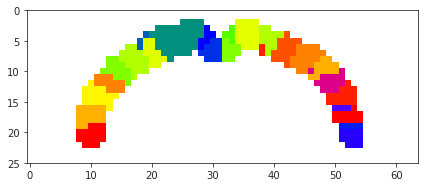

In [21]:
fig, ax = create_figure()
x = obj_all['sub-SLC02_ses-1']['cols'].numpy()
ax.imshow(mwh(x[..., 40].T == 0, x[..., 40].T), cmap='prism')
ax.set_ylim(25, 0)

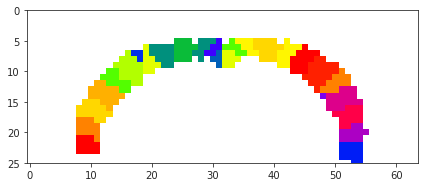

In [25]:
fig, ax = create_figure()
x = obj_all['sub-SLC09_ses-1']['cols'].numpy()
ax.imshow(mwh(x[..., 35].T == 0, x[..., 35].T), cmap='prism')
ax.set_ylim(25, 0);

## Fill ROIs 2d? (no longer needed)

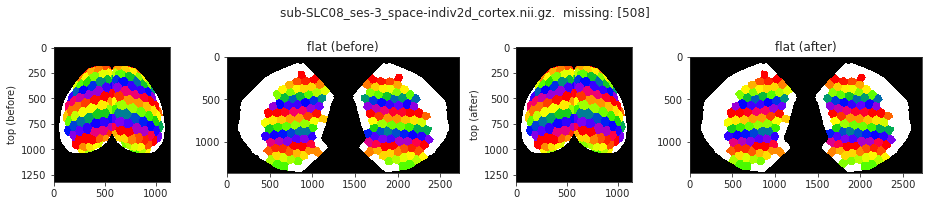

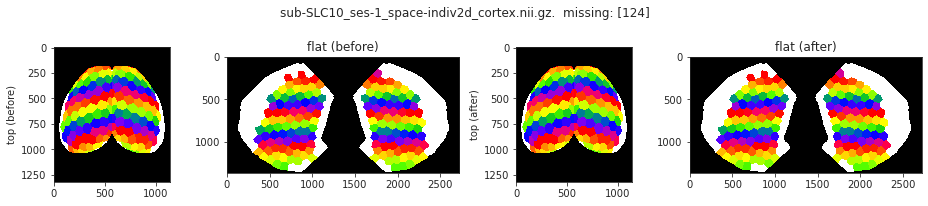

In [3]:
mice.parcel.fill_rois_2d(dry_run=True)

In [4]:
file = 'sub-SLC10_ses-1_space-indiv2d_cortex.nii.gz'
file = pjoin(mice.cfg.masks_dir, file)
ctx = ants.image_read(file)

file = 'sub-SLC10_ses-1_space-indiv2d_cols.nii.gz'
file = pjoin(mice.cfg.masks_dir, file)
col = ants.image_read(file)

ctx, col

(
    ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (512, 500, 1)
         Spacing    : (0.025, 0.025, 0.025)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
,
    ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (512, 500, 1)
         Spacing    : (0.025, 0.025, 0.025)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

)

In [5]:
ctx = ctx.numpy().squeeze()
col = col.numpy().squeeze()

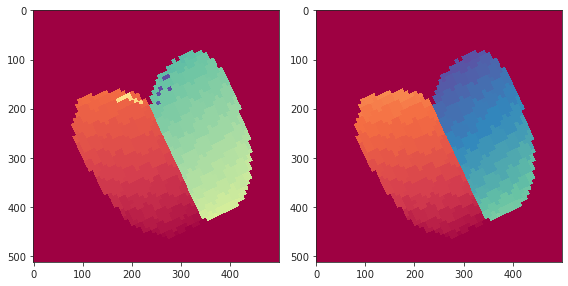

In [6]:
fig, axes = create_figure(1, 2, (8, 5))
axes[0].imshow(ctx, cmap='Spectral')
axes[1].imshow(col, cmap='Spectral')
plt.show()

In [7]:
regions_ctx = np.unique(ctx[ctx.nonzero()])
regions_col = np.unique(col[ctx.nonzero()])

len(regions_ctx), len(regions_col)

(170, 161)

In [8]:
hcl_ctx = mice.parcel.decode(regions_ctx)
hcl_col = mice.parcel.decode(regions_col)
(hcl_ctx[:, -1] == 0).sum(), (hcl_col[:, -1] == 0).sum()

(161, 161)

In [9]:
(hcl_ctx[:, -1] == 1).sum(), (hcl_col[:, -1] == 1).sum()

(9, 0)

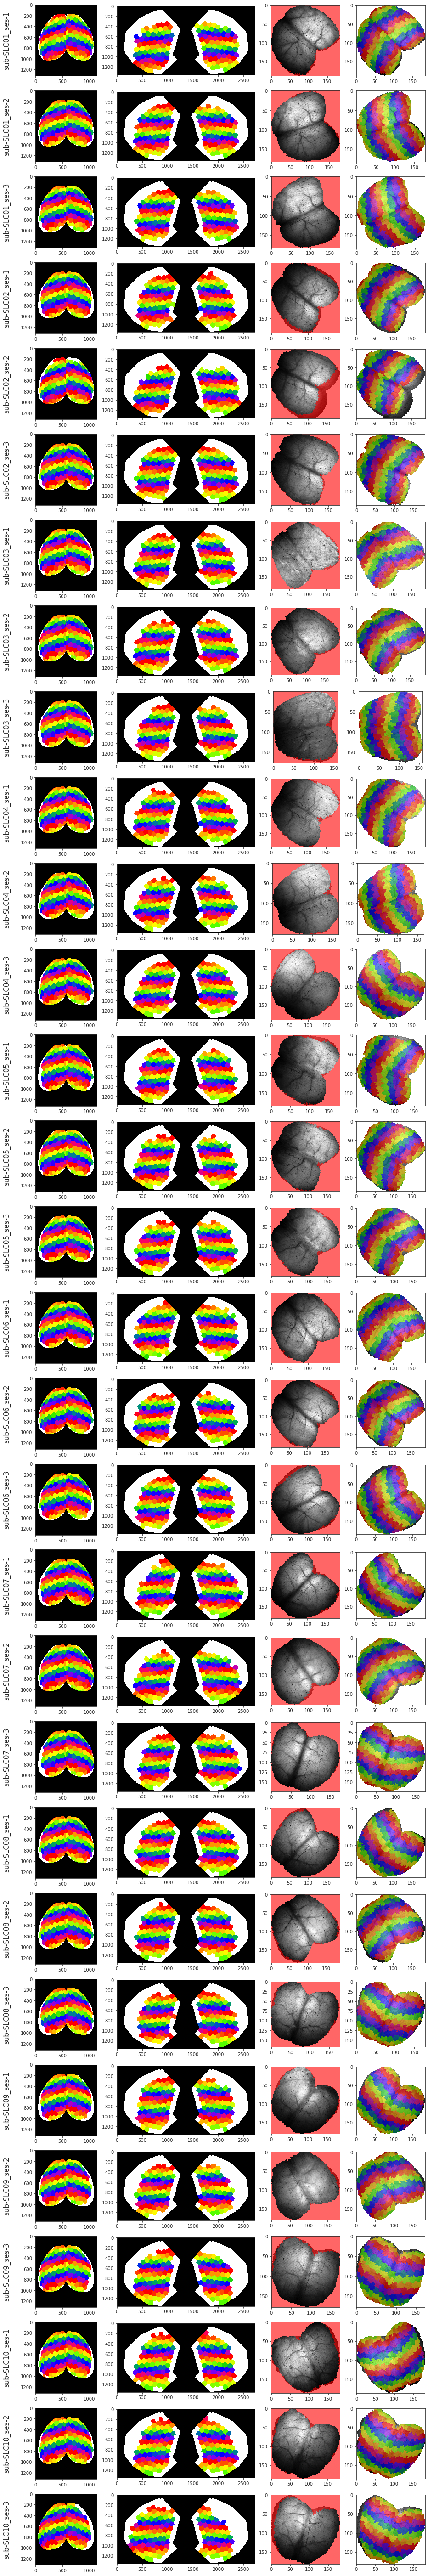

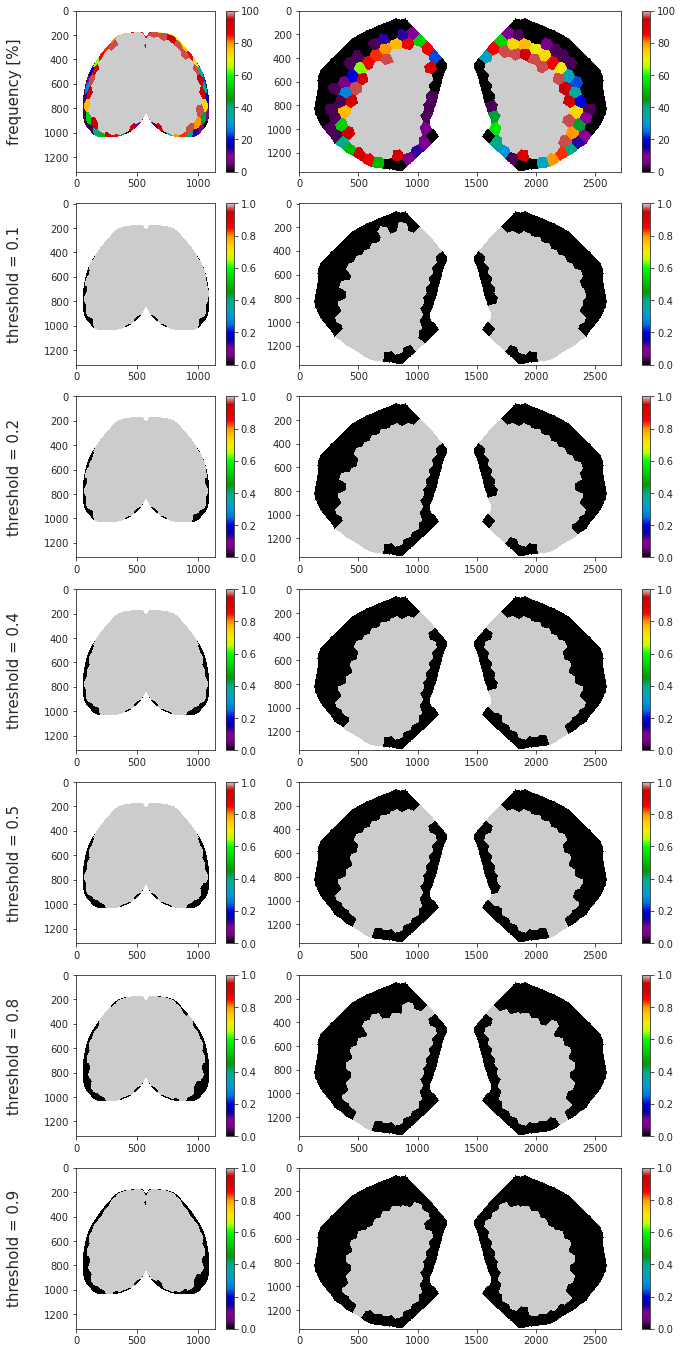

accept ratio: 81 %, reject ratio: 19 %, using a presence threshold of 10.0 %
a total of 166 regions were accepted

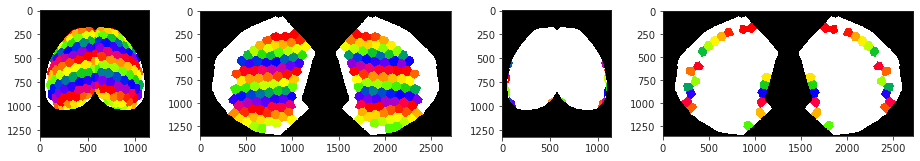

In [3]:
output = mice.parcel.show_accepted_regions_2d(mice)